## <span style="color:#db7d60">Setup</span>

In [2]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

In [3]:
model_name = 'model_5_9_1'
input_dataset_path = parent_dir / 'data' / 'dataset_5.csv'

print(f"Loading dataset from {input_dataset_path}")
input_data = data_manager.load_geant4_dataset(input_dataset_path, pad_token = np.nan)
print(f"Loaded {len(input_data)} events from {input_dataset_path}")

all_pt = []
for event in input_data:
    for particle in event:
        if np.isnan(particle[0]):
            continue
        pdgid, e, px, py, pz = particle
        pt = np.sqrt(px * px + py * py)
        all_pt.append(pt)
        
original_values = all_pt

Loading dataset from /pscratch/sd/e/eshy/particleGPT/data/dataset_5.csv
Loaded 10000000 events from /pscratch/sd/e/eshy/particleGPT/data/dataset_5.csv


Setup for quantile and log transformations.

In [1]:
current_bins = np.linspace(0, 35000, 350)
current_tokens = np.digitize(original_values, current_bins, right=False)

def plot_token_freq(tokens, title):
    counts = Counter(tokens)
    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]
    plt.figure(figsize=(12, 3))
    plt.bar(keys, values, width=1.0)
    plt.title(title)
    plt.xlabel("Token Index")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=200)
plt.title("Original Value Distribution")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plot_token_freq(current_tokens, "Current Tokenization Frequency")

NameError: name 'np' is not defined

Functions for quantile transformation.

In [7]:
def quantile_tokenizer(values, num_bins=350, token_min=0):
    bin_edges = np.quantile(values, q=np.linspace(0, 1, num_bins + 1))
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)
    tokens = token_min + bin_indices
    return tokens, bin_edges

def quantile_detokenize(tokens, bin_edges, token_min=0):
    indices = tokens - token_min
    # Clip just in case
    indices = np.clip(indices, 0, len(bin_edges) - 2)
    # Use bin centers (can replace with per-bin means for more precision)
    return 0.5 * (bin_edges[indices] + bin_edges[indices + 1])

def build_bin_means(values, bin_edges):
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)
    bin_means = np.zeros(len(bin_edges) - 1)
    for i in range(len(bin_means)):
        in_bin = values[bin_indices == i]
        bin_means[i] = in_bin.mean() if len(in_bin) > 0 else 0.5 * (bin_edges[i] + bin_edges[i + 1])
    return bin_means

This is quantile transformation.

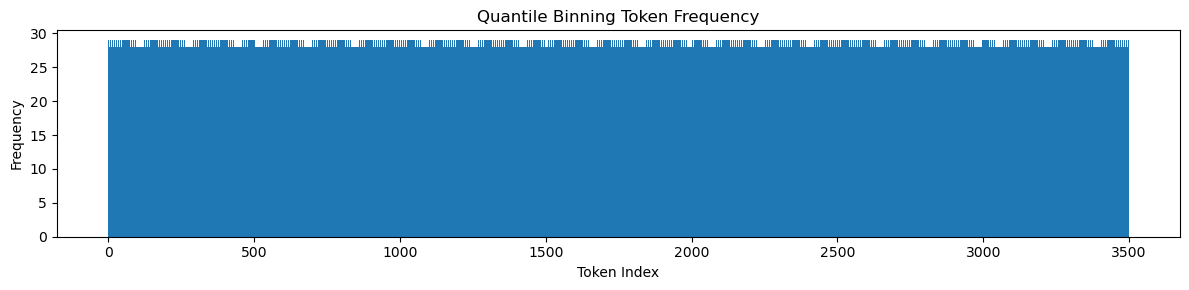

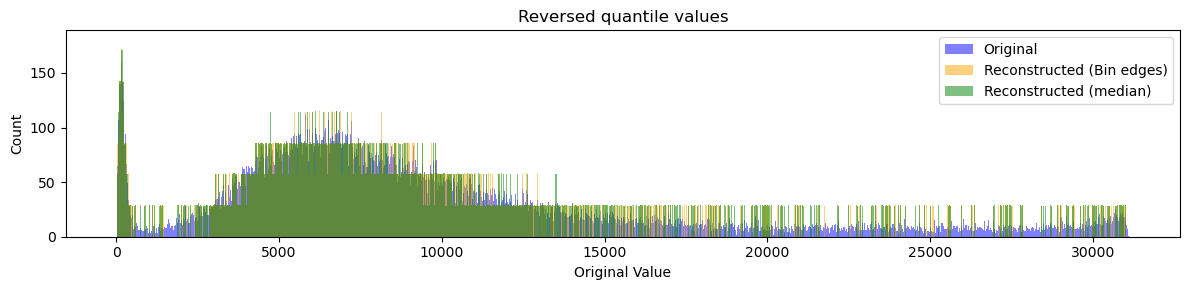

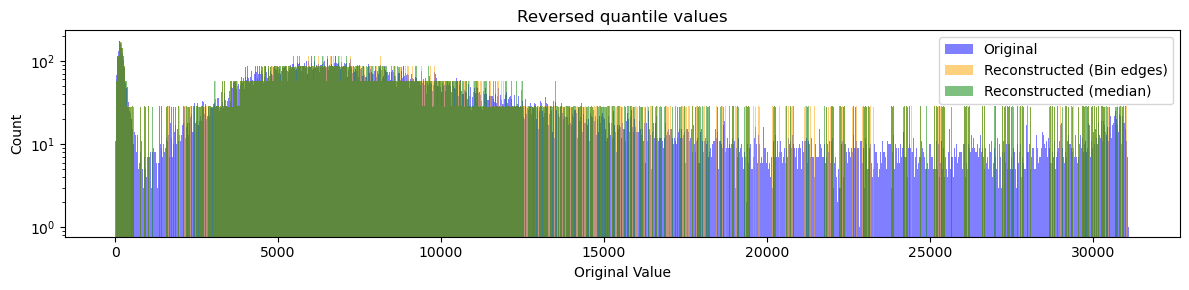

In [19]:
num_bins = 3500

quantile_tokens, quantile_edges = quantile_tokenizer(original_values, num_bins=num_bins)
reversed_quantile_values = quantile_detokenize(quantile_tokens, quantile_edges)

mean_per_bin = build_bin_means(original_values, quantile_edges)
reconstructed_eta = mean_per_bin[quantile_tokens - 0]

plot_token_freq(quantile_tokens, "Quantile Binning Token Frequency")

plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=num_bins, color='blue', alpha=0.5)
plt.hist(reversed_quantile_values, bins=num_bins, color='orange', alpha=0.5)
plt.hist(reconstructed_eta, bins=num_bins, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reconstructed (Bin edges)', 'Reconstructed (median)'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.yscale('log')
plt.hist(original_values, bins=num_bins, color='blue', alpha=0.5)
plt.hist(reversed_quantile_values, bins=num_bins, color='orange', alpha=0.5)
plt.hist(reconstructed_eta, bins=num_bins, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reconstructed (Bin edges)', 'Reconstructed (median)'])
plt.tight_layout()
plt.show()

This is the ideal. This is what we want to achieve with training.


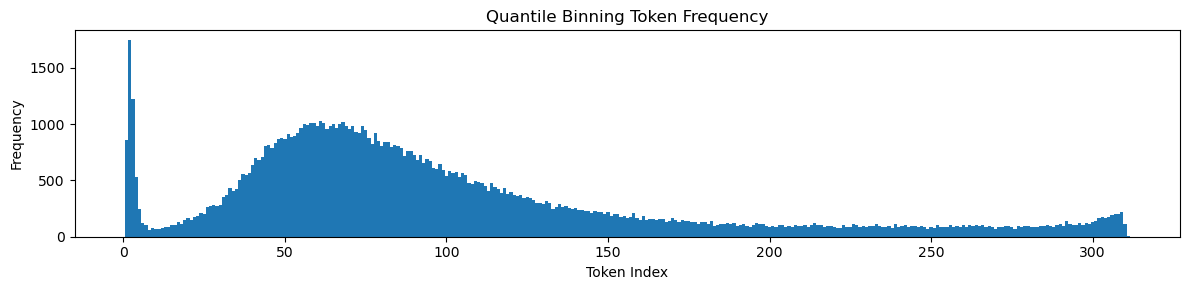

This the the quantile tokens (n_bins=35000) binned into 350 bins.


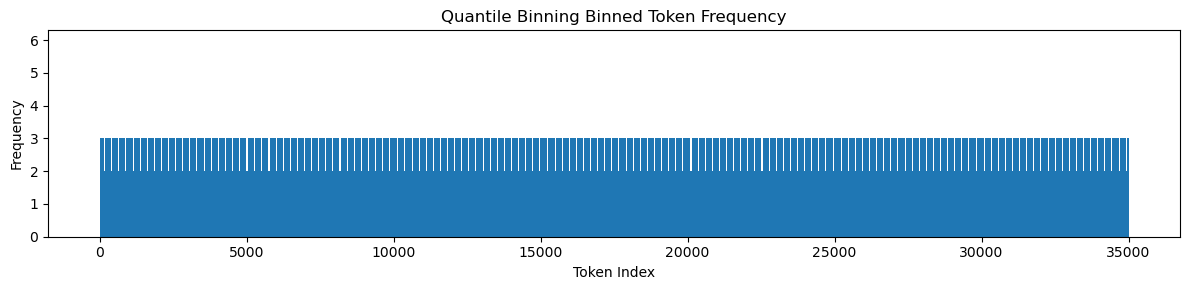

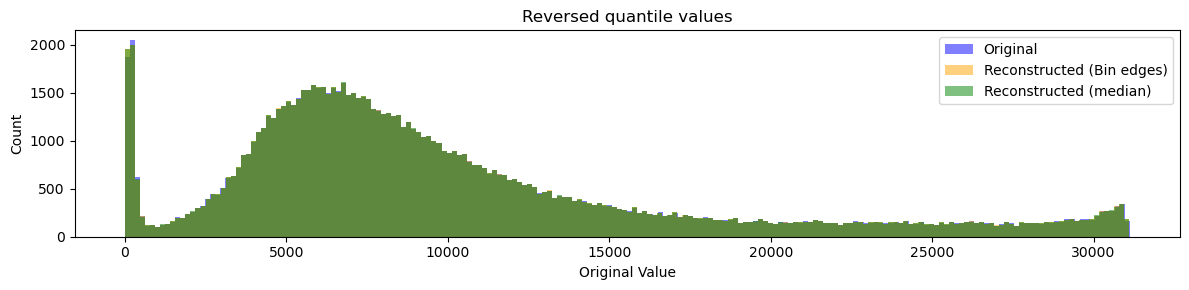

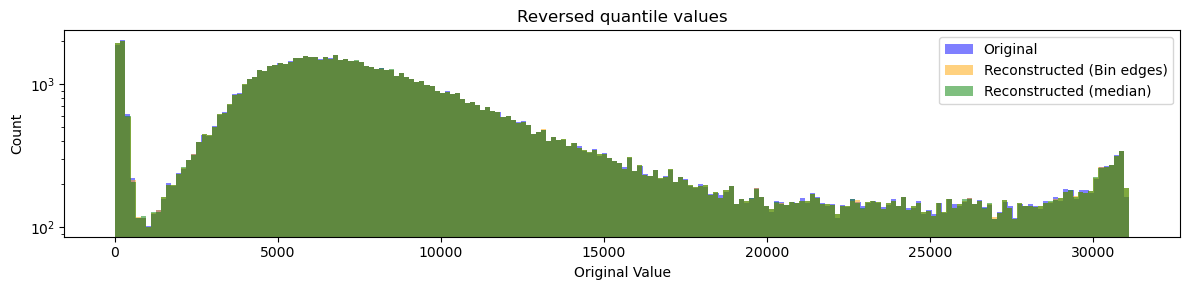

In [ ]:
print("This is the ideal. This is what we want to achieve with training.")
plot_token_freq(current_tokens, "Quantile Binning Token Frequency")

reversed_binned_quantile_values = quantile_detokenize(quantile_tokens * 1, quantile_edges)
mean_per_binned_bin = build_bin_means(original_values, quantile_edges)
reconstructed_binned_pt = mean_per_binned_bin[quantile_tokens * 1 - 0]

n_bins_for_plotting = 200

plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=n_bins_for_plotting, color='blue', alpha=0.5)
plt.hist(reversed_binned_quantile_values, bins=n_bins_for_plotting, color='orange', alpha=0.5)
plt.hist(reconstructed_binned_pt, bins=n_bins_for_plotting, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reconstructed (Bin edges)', 'Reconstructed (median)'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.yscale('log')
plt.hist(original_values, bins=n_bins_for_plotting, color='blue', alpha=0.5)
plt.hist(reversed_binned_quantile_values, bins=n_bins_for_plotting, color='orange', alpha=0.5)
plt.hist(reconstructed_binned_pt, bins=n_bins_for_plotting, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reconstructed (Bin edges)', 'Reconstructed (median)'])
plt.tight_layout()
plt.show()